# Default Setup

In [20]:
# Dataloading Stuff
from google.colab import drive
from sys import path
import os

# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split

from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span

import numpy as np
import pandas as pd

drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab/SingleLabel/'
path.append(path_root)
data_root = 'data/'

/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=59 mode='wb' closefd=True>
  del self._target, self._args, self._kwargs
/usr/lib/python3.6/threading.py:868: ResourceWarning: unclosed file <_io.FileIO name=61 mode='rb' closefd=True>
  del self._target, self._args, self._kwargs


Mounted at /content/drive


## Classifier with 2 Classes (Dataset only provides two classes)

Training on 'positive': 100%|██████████| 2/2 [00:45<00:00, 22.74s/it]



              precision    recall  f1-score   support

    negative       0.82      0.84      0.83      4859
    positive       0.84      0.82      0.83      4834

    accuracy                           0.83      9693
   macro avg       0.83      0.83      0.83      9693
weighted avg       0.83      0.83      0.83      9693


 Accuracy: 0.829



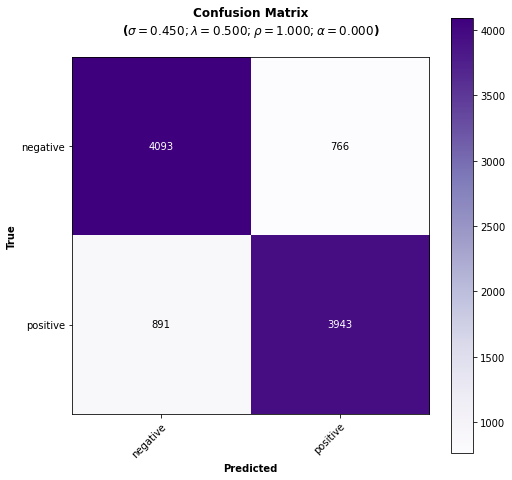

0.8290109449574925

In [21]:
df = pd.read_csv(path_root + data_root + "IMDBReviews/IMDB Dataset.csv", sep=";")
df['review'].replace({'<br />': '\\n'}, inplace=True, regex=True)
df.dropna(inplace=True)
text = df['review'].to_list()
labels = df['sentiment'].to_list()
X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2)

clf = SS3()
clf.fit(X_train, y_train)
Evaluation.test(clf, X_val, y_val, metric="f1-score")

## Calculate the all word overlap
1. Get dictionaries
2. Use dictionaries to find overlaping words

In [0]:
!rm -rf vocab_two && mkdir vocab_two
clf.save_vocab(path="./vocab_two")

In [23]:
def get_vocab(vocab_dir, attribute):
  list_of_vocabs = {}

  for filename in os.listdir(vocab_dir):
    csv_file = pd.read_csv(vocab_dir + filename)
    list_of_vocabs[filename] = csv_file

  for key, value in list_of_vocabs.items():
    list_of_vocabs[key] = list_of_vocabs[key][["term", attribute]]

  return list_of_vocabs

vocab_two = get_vocab('./vocab_two/', 'fr')
type(vocab_two)

dict

In [0]:
def convert_to_df(list_of_vocabs, attribute):
  terms = []
  for key, value in list_of_vocabs.items():
    terms = list(set(list_of_vocabs[key]["term"].tolist()) | set(terms))
  pd.Series(terms).value_counts()

  new_keys = ["term"]
  for value in list(list_of_vocabs.keys()):
    if "bigram" not in value and "trigram" not in value:
      new_keys.append(value)

  data = np.zeros((len(terms), len(new_keys)))
  # Generate Empty Dataframe
  new_vocab = pd.DataFrame(data=data, columns = new_keys, dtype=float)
  new_vocab["term"] = terms
  new_vocab = new_vocab.set_index("term")

  # Fill Dataframe with values
  for key, value in list_of_vocabs.items():
    if "bigrams" in key:
      key = key.replace("bigrams", "words")
    if "trigrams" in key:
      key = key.replace("trigrams", "words")
    for index, row in value.iterrows():
      new_vocab[key][row["term"]] = row[attribute]
  return new_vocab

two_df = convert_to_df(vocab_two, 'fr')

In [25]:
two_df

,ss3_vocab_negative(words).csv,ss3_vocab_positive(words).csv
term,,
NaN,6.0,41.0
gardening,6.0,2.0
mcavoy,2.0,13.0
salesman,41.0,39.0
immediacy,3.0,13.0
...,...,...
retreads,3.0,5.0
belching,6.0,3.0
chazen,0.0,3.0


In [0]:
from collections import defaultdict

def calc_word_overlap(vocab_df, important=False, a=None):
  overlap = defaultdict(int)
  counter_all = 0

  for keys, row in vocab_df.iterrows():
    if not a:
      if np.count_nonzero(row) > 1:
        indices = row.to_numpy().nonzero()
        res_keys = vocab_df.keys()[indices[0]]
        overlap[tuple(res_keys)] += 1
        counter_all += 1
    else:
      if np.count_nonzero(row.ge(a)) > 1:
        indices = np.where(row.to_numpy() > a)
        res_keys = vocab_df.keys()[indices[0]]
        overlap[tuple(res_keys)] += 1
        counter_all += 1
  return overlap, counter_all

two_overlap, two_counter = calc_word_overlap(two_df)

In [27]:
sorted(two_overlap.items(), key=lambda kv: kv[1], reverse=True)

[(('ss3_vocab_negative(words).csv', 'ss3_vocab_positive(words).csv'), 31592)]

In [28]:
print('Counter 2 Classes:', two_counter)
print('2 Classes Ratio:', two_counter/two_df.shape[0])

Counter 2 Classes: 31592
2 Classes Ratio: 0.5621052256996958


## Calculate the important word overlap

In [29]:
vocab_two_cv = get_vocab('./vocab_two/', 'cv')
vocab_two_cv_df = convert_to_df(vocab_two_cv, 'cv')
two_overlap_cv, two_counter_cv = calc_word_overlap(vocab_two_cv_df)#, important=True, a=a)
vocab_two_cv_df

,ss3_vocab_negative(words).csv,ss3_vocab_positive(words).csv
term,,
NaN,0.000428,0.015925
gardening,0.000161,0.000098
mcavoy,0.000050,0.000816
salesman,0.000232,0.000374
immediacy,0.000060,0.000669
...,...,...
retreads,0.000061,0.000197
belching,0.000132,0.000118
chazen,0.000000,0.000384


In [11]:
two_overlap_cv

defaultdict(int,
            {('ss3_vocab_negative(words).csv',
              'ss3_vocab_positive(words).csv'): 31510})

In [12]:
print('Counter 2 Classes:', two_counter_cv)
print('Counter 2 Classes:', two_counter_cv/vocab_two_cv_df.shape[0])

Counter 2 Classes: 31510
Counter 2 Classes: 0.5593722816921411


In [13]:
vocab_two_cv_df.apply(np.count_nonzero, axis=0)

ss3_vocab_negative(words).csv    42674
ss3_vocab_positive(words).csv    45167
dtype: int64

In [14]:
two_df.apply(np.count_nonzero, axis=0)

ss3_vocab_negative(words).csv    42674
ss3_vocab_positive(words).csv    45171
dtype: int64

## UTIL

In [19]:
import util
!rm -rf vocab_two && mkdir vocab_two
overlap, counter, ratio = util.calc_overlap(clf, './vocab_two', 'cv', True, 0.000001)
print("Overlap Ratio All Words", ratio)

Overlap Ratio All Words 0.5593722816921411
